In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
import torch_harmonics as th
from torch_harmonics.random_fields import GaussianRandomFieldS2

from torch.utils.data import DataLoader, TensorDataset

import os
os.chdir('../methods')
import lsci, supr, conf, uqno, prob_don, quant_don, gaus
os.chdir('../gpsims')

os.chdir('../models_and_metrics')
from models import *
from metrics import * 
from utility import *
os.chdir('../gpsims')

In [2]:
kernel = jnp.ones(5)/5

rng0 = 0
rng = random.PRNGKey(rng0)
key1, key2, key3 = random.split(rng, 3)

### train
n, p = 1000, 50
beta = random.normal(rng, (5,))
bias = 1

xtrain = conv(conv(random.normal(key1, (n, p)), kernel), kernel)
sigma = jnp.std(xtrain, axis = 1)
sigma = sigma - jnp.mean(sigma) + 1
sigma = sigma/sigma
epsilon = sigma[:,None] * conv(conv(random.normal(key2, (n, p)), kernel), kernel)

ytrain = bias + conv(xtrain, beta) + epsilon
xtrain = xtrain[:,None,:,None]
ytrain = ytrain[:,None,:,None]

### valid
rng0 += 1
rng = random.PRNGKey(rng0)
key1, key2, key3 = random.split(rng, 3)

xval = conv(conv(random.normal(key1, (n, p)), kernel), kernel)
sigma = jnp.std(xval, axis = 1)
sigma = sigma - jnp.mean(sigma) + 1
sigma = sigma/sigma
epsilon = sigma[:,None] * conv(conv(random.normal(key2, (n, p)), kernel), kernel)

yval = bias + conv(xval, beta) + epsilon
xval = xval[:,None,:,None]
yval = yval[:,None,:,None]


### test
ntest = 250
rng0 += 1
rng = random.PRNGKey(rng0)
key1, key2, key3 = random.split(rng, 3)

xtest = conv(conv(random.normal(key1, (ntest, p)), kernel), kernel)
sigma = jnp.std(xtest, axis = 1)
sigma = sigma - jnp.mean(sigma) + 1
sigma = sigma/sigma
epsilon = sigma[:,None] * conv(conv(random.normal(key2, (ntest, p)), kernel), kernel)

ytest = bias + conv(xtest, beta) + epsilon
xtest = xtest[:,None,:,None]
ytest = ytest[:,None,:,None]

In [3]:
train_data = TensorDataset(jax2torch(xtrain), jax2torch(ytrain))
train_loader = DataLoader(train_data, batch_size = 30, shuffle = True)

In [4]:
epochs = 100
trace = []
lag, lead = 1, 1

model = DeepANO(lag, 50, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(model, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = train_step(model, optim, xt, yt)
        trace.append(loss)

model.eval()

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
yval_hat = model(xval)
ytest_hat = model(xtest)

In [6]:
nproj = npc = 25
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nval = xval.shape[0]

lsc1_risk, lsc1_width = [], []

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()

state = lsci.lsci_state(xval.squeeze(), rval, npc)
pca_state = state[-1]

for i in trange(0, ytest.shape[0]):
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma1)
    lsc1_risk.append(risk(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))

  0%|          | 0/250 [00:00<?, ?it/s]

In [7]:
nproj = 40
alpha = 0.1
nval = xval.shape[0]

gamma_seq = [0.025, 0.05, 0.1, 0.25, 0.5, 0.9]
m = len(gamma_seq)

lsci_risk = []
lsci_width = []
lsci_time = []

yval_hat = model(xval)
ytest_hat = model(xtest)

yval = yval.reshape(yval.shape[0], -1)
yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
state = lsci.lsci_state(xval.squeeze(), rval, npc)
pca_state = state[-1]

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
conf_risk = []
conf_width = []

for i in trange(0, ntest):
    # LSCI
    _rc = np.zeros(m)
    _width = np.zeros(m)
    for j in range(m):
        lsc_lower, lsc_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma_seq[j])
        _rc[j] = risk(lsc_lower, lsc_upper, rtest[i])
        _width[j] = jnp.median(lsc_upper - lsc_lower)
        
    lsci_risk.append(_rc)
    lsci_width.append(_width)
    
    conf_risk.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.mean(conf_upper - conf_lower))
    
lsci_risk = np.array(lsci_risk)
conf_risk = np.array(conf_risk)
lsci_width = np.array(lsci_width)
conf_width = np.array(conf_width)

metrics1 = [lsci_risk, lsci_width, conf_risk, conf_width]

  0%|          | 0/250 [00:00<?, ?it/s]

In [8]:
nsamp_seq = [125, 250, 500, 1000, 2000, 4000]
m = len(gamma_seq)

lsci_risk = []
lsci_width = []
lsci_time = []

yval_hat = model(xval)
ytest_hat = model(xtest)

yval = yval.reshape(yval.shape[0], -1)
yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
state = lsci.lsci_state(xval.squeeze(), rval, npc)
pca_state = state[-1]

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
conf_risk = []
conf_width = []

for i in trange(0, ntest):
    # LSCI
    _rc = np.zeros(m)
    _width = np.zeros(m)
    for j in range(m):
        lsc_lower, lsc_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, nsamp_seq[j], 0.1)
        _rc[j] = risk(lsc_lower, lsc_upper, rtest[i])
        _width[j] = jnp.median(lsc_upper - lsc_lower)
        
    lsci_risk.append(_rc)
    lsci_width.append(_width)
    
    conf_risk.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.mean(conf_upper - conf_lower))
    
lsci_risk = np.array(lsci_risk)
conf_risk = np.array(conf_risk)
lsci_width = np.array(lsci_width)
conf_width = np.array(conf_width)

metrics2 = [lsci_risk, lsci_width, conf_risk, conf_width]

  0%|          | 0/250 [00:00<?, ?it/s]

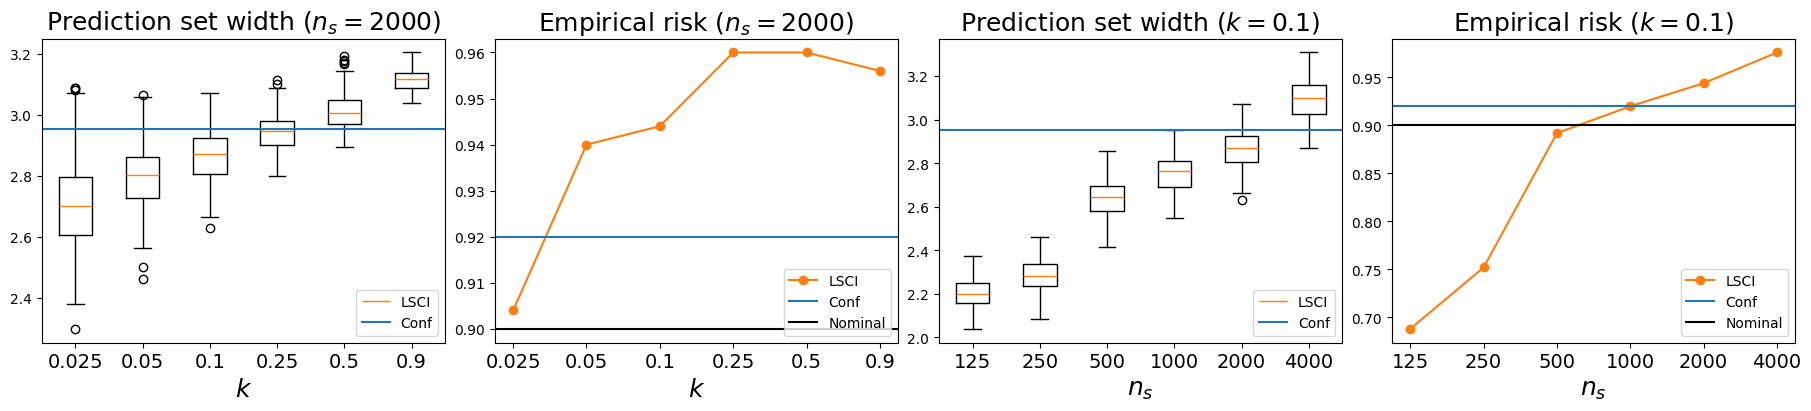

In [9]:
fig, ax = plt.subplots(1, 4, constrained_layout = True, figsize = (18, 4))

lsci_risk, lsci_width, conf_risk, conf_width = metrics1
ax[0].boxplot(lsci_width, tick_labels = gamma_seq, label = 'LSCI')
ax[0].axhline(np.mean(conf_width), c = 'C0', label = 'Conf')
ax[0].set_title('Prediction set width ($n_{s} = 2000$)', fontsize = 18)
ax[0].set_xlabel('$k$', fontsize = 18)
ax[0].set_xticklabels(gamma_seq, fontsize = 14)
ax[0].legend(loc = 'lower right')

ax[1].plot(np.mean(lsci_risk >= 0.99, axis = 0), c = 'C1', marker = 'o', label = 'LSCI')
ax[1].axhline(np.mean(conf_risk >= 0.99, axis = 0), label = 'Conf')
ax[1].axhline(0.9, c = 'black', label = 'Nominal')
ax[1].set_xticks(np.arange(6))
ax[1].set_xticklabels(gamma_seq, fontsize = 14)
ax[1].set_title('Empirical risk ($n_{s} = 2000$)', fontsize = 18)
ax[1].set_xlabel('$k$', fontsize = 18)
ax[1].legend(loc = 'lower right')

lsci_risk, lsci_width, conf_risk, conf_width = metrics2
ax[2].boxplot(lsci_width, tick_labels = nsamp_seq, label = 'LSCI')
ax[2].axhline(np.mean(conf_width), c = 'C0', label = 'Conf')
ax[2].set_title('Prediction set width ($k = 0.1$)', fontsize = 18)
ax[2].set_xlabel('$n_{s}$', fontsize = 18)
ax[2].set_xticklabels(nsamp_seq, fontsize = 14)
ax[2].legend(loc = 'lower right')

ax[3].plot(np.mean(lsci_risk >= 0.99, axis = 0), c = 'C1', marker = 'o', label = 'LSCI')
ax[3].axhline(np.mean(conf_risk >= 0.99, axis = 0), label = 'Conf')
ax[3].axhline(0.9, c = 'black', label = 'Nominal')
ax[3].set_xticks(np.arange(6))
ax[3].set_xticklabels(nsamp_seq, fontsize = 14)
ax[3].set_title('Empirical risk ($k = 0.1$)', fontsize = 18)
ax[3].set_xlabel('$n_{s}$', fontsize = 18)
ax[3].legend(loc = 'lower right')
plt.show()

In [11]:
fpc_seq = [5, 10, 20, 30, 40, 50]
m = len(fpc_seq)

lsci_risk = []
lsci_width = []
lsci_time = []

yval_hat = model(xval)
ytest_hat = model(xtest)

yval = yval.reshape(yval.shape[0], -1)
yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
state = lsci.lsci_state(xval.squeeze(), rval, npc)
pca_state = state[-1]

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
conf_risk = []
conf_width = []

for i in trange(0, ntest):
    _rc = np.zeros(m)
    _width = np.zeros(m)
    for j in range(m):

        state = lsci.lsci_state(xval.squeeze(), rval, fpc_seq[j])
        pca_state = state[-1]

        conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
        
        lsc_lower, lsc_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, 0.1)
        _rc[j] = risk(lsc_lower, lsc_upper, rtest[i])
        _width[j] = jnp.median(lsc_upper - lsc_lower)
        
    lsci_risk.append(_rc)
    lsci_width.append(_width)
    
    conf_risk.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.mean(conf_upper - conf_lower))
    
lsci_risk = np.array(lsci_risk)
conf_risk = np.array(conf_risk)
lsci_width = np.array(lsci_width)
conf_width = np.array(conf_width)

metrics3 = [lsci_risk, lsci_width, conf_risk, conf_width]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

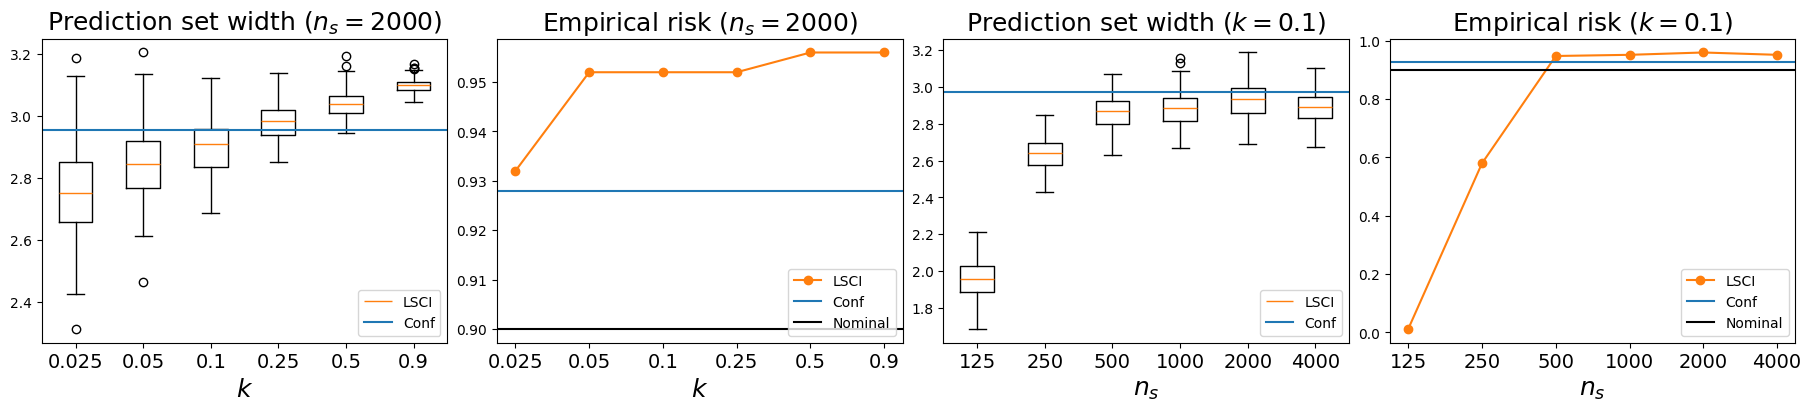

In [12]:
fig, ax = plt.subplots(1, 4, constrained_layout = True, figsize = (18, 4))

lsci_risk, lsci_width, conf_risk, conf_width = metrics1
ax[0].boxplot(lsci_width, tick_labels = gamma_seq, label = 'LSCI')
ax[0].axhline(np.mean(conf_width), c = 'C0', label = 'Conf')
ax[0].set_title('Prediction set width ($n_{s} = 2000$)', fontsize = 18)
ax[0].set_xlabel('$k$', fontsize = 18)
ax[0].set_xticklabels(gamma_seq, fontsize = 14)
ax[0].legend(loc = 'lower right')

ax[1].plot(np.mean(lsci_risk >= 0.99, axis = 0), c = 'C1', marker = 'o', label = 'LSCI')
ax[1].axhline(np.mean(conf_risk >= 0.99, axis = 0), label = 'Conf')
ax[1].axhline(0.9, c = 'black', label = 'Nominal')
ax[1].set_xticks(np.arange(6))
ax[1].set_xticklabels(gamma_seq, fontsize = 14)
ax[1].set_title('Empirical risk ($n_{s} = 2000$)', fontsize = 18)
ax[1].set_xlabel('$k$', fontsize = 18)
ax[1].legend(loc = 'lower right')

lsci_risk, lsci_width, conf_risk, conf_width = metrics2
ax[2].boxplot(lsci_width, tick_labels = nsamp_seq, label = 'LSCI')
ax[2].axhline(np.mean(conf_width), c = 'C0', label = 'Conf')
ax[2].set_title('Prediction set width ($k = 0.1$)', fontsize = 18)
ax[2].set_xlabel('$n_{s}$', fontsize = 18)
ax[2].set_xticklabels(nsamp_seq, fontsize = 14)
ax[2].legend(loc = 'lower right')

ax[3].plot(np.mean(lsci_risk >= 0.99, axis = 0), c = 'C1', marker = 'o', label = 'LSCI')
ax[3].axhline(np.mean(conf_risk >= 0.99, axis = 0), label = 'Conf')
ax[3].axhline(0.9, c = 'black', label = 'Nominal')
ax[3].set_xticks(np.arange(6))
ax[3].set_xticklabels(nsamp_seq, fontsize = 14)
ax[3].set_title('Empirical risk ($k = 0.1$)', fontsize = 18)
ax[3].set_xlabel('$n_{s}$', fontsize = 18)
ax[3].legend(loc = 'lower right')
plt.show()

In [45]:
# rng = random.PRNGKey(0)
# ind = random.randint(rng, (n,), 0, n)

# # sigma = 0.25 * (1.15 + sd)
# res_sd = sigma[:ntest]
# rcc_lsci = [np.corrcoef([lsci_risk[:,i] >= 0.99, res_sd])[0,1] for i in range(6)]

In [46]:
# rcc_lsci = [np.corrcoef([lsci_risk[:,i] >= 0.99, res_sd])[0,1] for i in range(6)]
# rcc_conf = np.corrcoef([conf_risk >= 0.99, res_sd])[0,1]

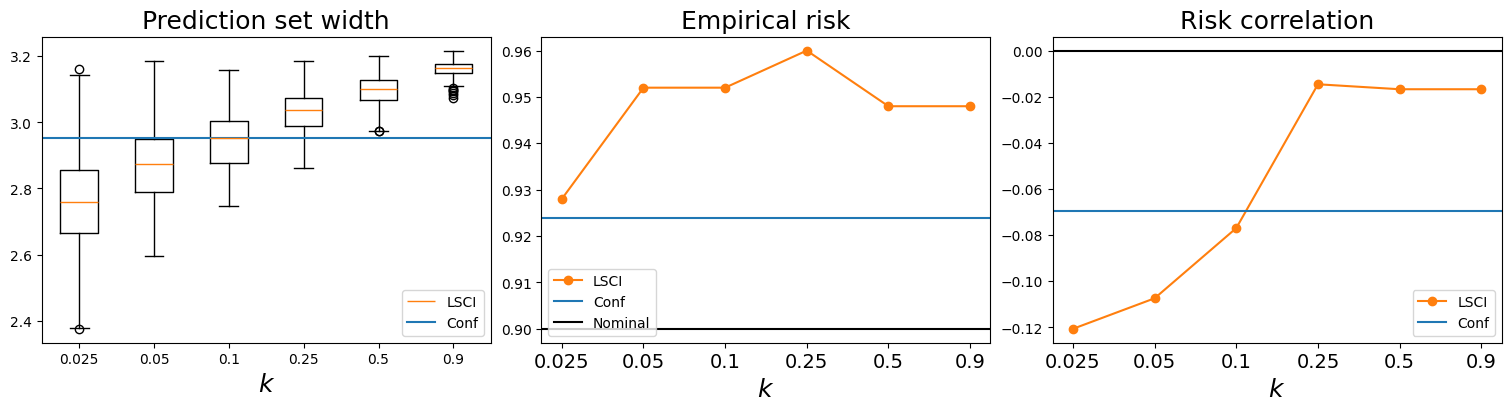

In [47]:
fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize = (15, 4))

ax[0].boxplot(lsci_width, tick_labels = gamma_seq, label = 'LSCI')
ax[0].axhline(np.mean(conf_width), c = 'C0', label = 'Conf')
ax[0].set_title('Prediction set width', fontsize = 18)
ax[0].set_xlabel('$k$', fontsize = 18)
ax[0].legend()

ax[1].plot(np.mean(lsci_risk >= 0.99, axis = 0), c = 'C1', marker = 'o', label = 'LSCI')
ax[1].axhline(np.mean(conf_risk >= 0.99, axis = 0), label = 'Conf')
ax[1].axhline(0.9, c = 'black', label = 'Nominal')
ax[1].set_xticks(np.arange(6))
ax[1].set_xticklabels(gamma_seq, fontsize = 14)
ax[1].set_title('Empirical risk', fontsize = 18)
ax[1].set_xlabel('$k$', fontsize = 18)
ax[1].legend()

ax[2].plot(rcc_lsci, marker = 'o', c = 'C1', label = 'LSCI')
ax[2].axhline(0.0, c = 'black')
ax[2].axhline(rcc_conf, c = 'C0', label = 'Conf')
ax[2].set_xticks(np.arange(6))
ax[2].set_xticklabels(gamma_seq, fontsize = 14)
ax[2].set_title('Risk correlation', fontsize = 18)
ax[2].set_xlabel('$k$', fontsize = 18)
ax[2].legend()

plt.show()

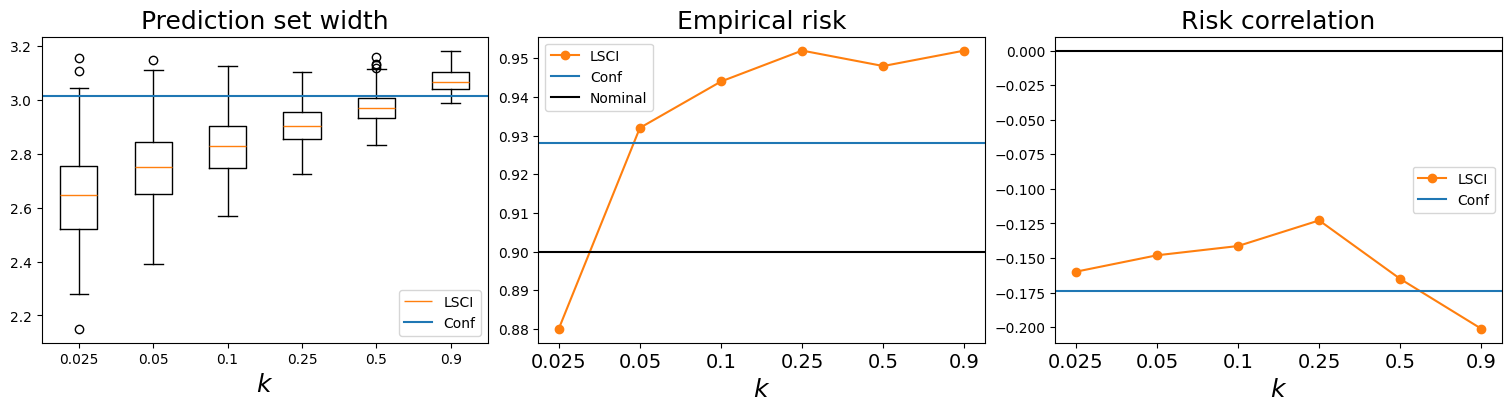

In [37]:
fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize = (15, 4))

ax[0].boxplot(lsci_width, tick_labels = gamma_seq, label = 'LSCI')
ax[0].axhline(np.mean(conf_width), c = 'C0', label = 'Conf')
ax[0].set_title('Prediction set width', fontsize = 18)
ax[0].set_xlabel('$k$', fontsize = 18)
ax[0].legend()

ax[1].plot(np.mean(lsci_risk >= 0.99, axis = 0), c = 'C1', marker = 'o', label = 'LSCI')
ax[1].axhline(np.mean(conf_risk >= 0.99, axis = 0), label = 'Conf')
ax[1].axhline(0.9, c = 'black', label = 'Nominal')
ax[1].set_xticks(np.arange(6))
ax[1].set_xticklabels(gamma_seq, fontsize = 14)
ax[1].set_title('Empirical risk', fontsize = 18)
ax[1].set_xlabel('$k$', fontsize = 18)
ax[1].legend()

ax[2].plot(rcc_lsci, marker = 'o', c = 'C1', label = 'LSCI')
ax[2].axhline(0.0, c = 'black')
ax[2].axhline(rcc_conf, c = 'C0', label = 'Conf')
ax[2].set_xticks(np.arange(6))
ax[2].set_xticklabels(gamma_seq, fontsize = 14)
ax[2].set_title('Risk correlation', fontsize = 18)
ax[2].set_xlabel('$k$', fontsize = 18)
ax[2].legend()

plt.show()

In [48]:
nproj = 40
alpha = 0.1
nval = xval.shape[0]

nsamp_seq = [125, 250, 500, 1000, 2000, 4000]
m = len(gamma_seq)

lsci_risk = []
lsci_width = []
lsci_time = []

yval_hat = model(xval)
ytest_hat = model(xtest)

yval = yval.reshape(yval.shape[0], -1)
yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
state = lsci.lsci_state(xval.squeeze(), rval, npc)
pca_state = state[-1]

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
conf_risk = []
conf_width = []

for i in trange(0, ntest):
    # LSCI
    _rc = np.zeros(m)
    _width = np.zeros(m)
    for j in trange(m, leave = False):
        lsc_lower, lsc_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, nsamp_seq[j], 0.1)
        _rc[j] = risk(lsc_lower, lsc_upper, rtest[i])
        _width[j] = jnp.median(lsc_upper - lsc_lower)
        
    lsci_risk.append(_rc)
    lsci_width.append(_width)
    
    conf_risk.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.mean(conf_upper - conf_lower))
    
lsci_risk = np.array(lsci_risk)
conf_risk = np.array(conf_risk)
lsci_width = np.array(lsci_width)
conf_width = np.array(conf_width)

metrics2 = [lsci_risk, lsci_width, conf_risk, conf_width]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [49]:
# rcc_lsci = [np.corrcoef([lsci_risk[:,i] >= 0.99, res_sd])[0,1] for i in range(6)]
# rcc_conf = np.corrcoef([conf_risk >= 0.99, res_sd])[0,1]

# run2 = [lsci_risk, lsci_width, conf_risk, conf_width]

In [59]:
metrics2 = [lsci_risk, lsci_width, conf_risk, conf_width]

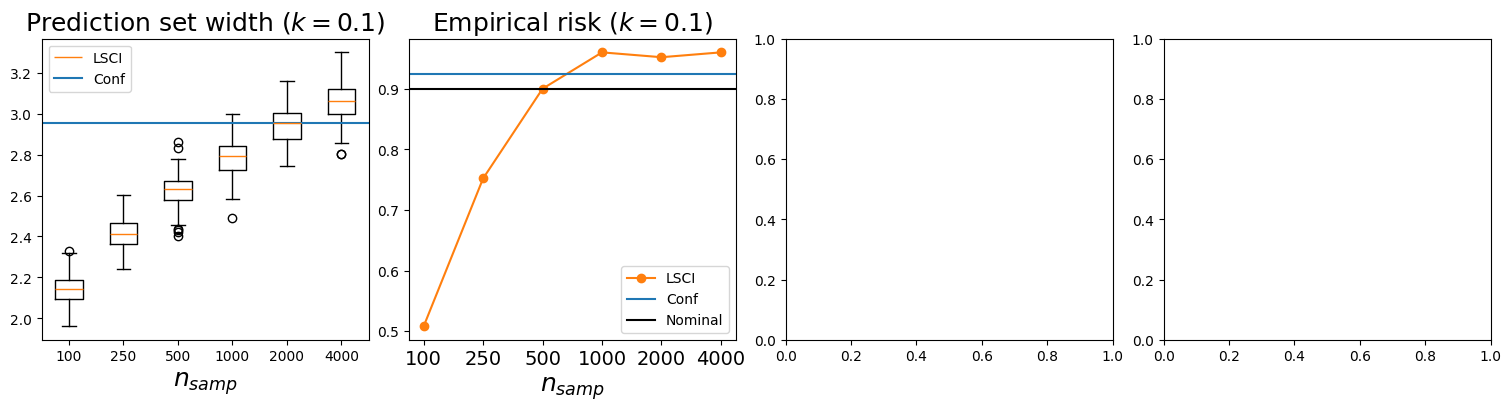

In [60]:
fig, ax = plt.subplots(1, 4, constrained_layout = True, figsize = (15, 4))

ax[0].boxplot(lsci_width, tick_labels = nsamp_seq, label = 'LSCI')
ax[0].axhline(np.mean(conf_width), c = 'C0', label = 'Conf')
ax[0].set_title('Prediction set width ($k = 0.1$)', fontsize = 18)
ax[0].set_xlabel('$n_{samp}$', fontsize = 18)
ax[0].legend()

ax[1].plot(np.mean(lsci_risk >= 0.99, axis = 0), c = 'C1', marker = 'o', label = 'LSCI')
ax[1].axhline(np.mean(conf_risk >= 0.99, axis = 0), label = 'Conf')
ax[1].axhline(0.9, c = 'black', label = 'Nominal')
ax[1].set_xticks(np.arange(6))
ax[1].set_xticklabels(nsamp_seq, fontsize = 14)
ax[1].set_title('Empirical risk ($k = 0.1$)', fontsize = 18)
ax[1].set_xlabel('$n_{samp}$', fontsize = 18)
ax[1].legend()

# ax[2].plot(rcc_lsci, marker = 'o', c = 'C1', label = 'LSCI')
# ax[2].axhline(0.0, c = 'black')
# ax[2].axhline(rcc_conf, c = 'C0', label = 'Conf')
# ax[2].set_xticks(np.arange(6))
# ax[2].set_xticklabels(nsamp_seq, fontsize = 14)
# ax[2].set_title('Risk correlation', fontsize = 18)
# ax[2].set_xlabel('$n_{samp}$', fontsize = 18)
# ax[2].legend()

plt.show()

In [314]:
# res_sd = np.std(rtest[0:150], axis = 1)
res_sd = sigma[0:150]
rc_corr = [np.corrcoef([lsci_rc[:,i], res_sd])[0,1] for i in range(6)]
width_corr = [np.corrcoef([lsci_width[:,i], res_sd])[0,1] for i in range(6)]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 4))

ax[0].plot(np.mean(lsci_rc > 0.99, axis = 0), marker = 'o')
ax[0].axhline(0.9)

ax[1].plot(rc_corr, marker = 'o')
ax[1].axhline(0.0)
plt.show()

In [201]:
quant = DeepANO(lag, 50, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(quant, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = quant_step(quant, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/500 [00:00<?, ?it/s]

In [202]:
model.eval()
quant.eval()

In [203]:
yval_hat = model(xval)
ytest_hat = model(xtest)
yval_quant = quant(xval)
ytest_quant = quant(xtest)

In [204]:
# nproj = 90
# gamma1 = 0.2
# alpha = 0.1
# nval = xval.shape[0]
# alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval + 1))/(gamma1*nval)

In [205]:
yval = yval.reshape(yval.shape[0], -1)
yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
# pca_state = lsci.phi_state(yval, yval_hat, nproj)

In [206]:
# UQNO lambda estimate
yval_quant = yval.reshape(yval_quant.shape[0], -1)
ytest_quant = ytest_quant.reshape(ytest_quant.shape[0], -1)

alpha = 0.1
delta = 0.01
# m = 32*64
m = 100
tau = 1.1 * jnp.sqrt(-jnp.log(delta)/(2*m))
sg = jnp.abs(yval - yval_hat) / yval_quant
sg = jnp.quantile(sg, 1-alpha+tau, axis = (1))
nval = sg.shape[0]

adj_alpha = 1 - jnp.ceil((nval + 1) * (delta - jnp.exp(-2*m*tau**2)))/nval
lam_uqno = jnp.quantile(sg, adj_alpha)
lam_uqno

Array(0.08691277, dtype=float32)

In [213]:
nproj = 90
gamma1 = 0.1
gamma2 = 0.3
alpha = 0.1
nval = xval.shape[0]
alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval + 1))/(gamma1*nval)
alpha2 = 1 - jnp.ceil((1-alpha) * (gamma2*nval + 1))/(gamma2*nval)

lsc1_rc = []
lsc2_rc = []
lsc3_rc = []
conf_rc = []
supr_rc = []
uqn1_rc = []
drop_rc = []
orcl_rc = []

lsc1_width = []
lsc2_width = []
lsc3_width = []
conf_width = []
supr_width = []
uqn1_width = []
drop_width = []
orcl_width = []

yval = yval.reshape(yval.shape[0], -1)
yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
pca_state = lsci.phi_state(yval, yval_hat, nproj)

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)

for i in trange(0, ytest.shape[0]):
# for i in trange(0, 100):

    # Oracle
    orcl_lower = -(jnp.abs(rtest[i]) + 1e-4)
    orcl_upper = jnp.abs(rtest[i]) + 1e-4
    orcl_rc.append(risk(orcl_lower, orcl_upper, rtest[i]))
    orcl_width.append(jnp.median(orcl_upper - orcl_lower))
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[i], pca_state, alpha1, gamma1, 2000)
    lsc1_rc.append(risk(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # LSCI
    lsc2_lower, lsc2_upper = lsci.lsci(rval, xval, xtest[i], pca_state, alpha2, gamma2, 2000)
    lsc2_rc.append(risk(lsc2_lower, lsc2_upper, rtest[i]))
    lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))

    model.train()
    drop_set = jnp.stack([model(xtest[i:(i+1)]).squeeze() for _ in range(500)])
    drop_lower = jnp.quantile(drop_set, alpha/2, axis = 0)
    drop_upper = jnp.quantile(drop_set, 1 - alpha/2, axis = 0)
    model.eval()
    
    drop_rc.append(risk(drop_lower, drop_upper, rtest[i]))
    drop_width.append(jnp.median(drop_upper - drop_lower))
    
    # CONF 
    conf_rc.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.median(conf_upper - conf_lower))
    
    # SUPR
    supr_rc.append(risk(supr_lower, supr_upper, rtest[i]))
    supr_width.append(jnp.median(supr_upper - supr_lower))
    
    # UQNO
    uqn1_rc.append(risk(uqn1_lower[i], uqn1_upper[i], rtest[i]))
    uqn1_width.append(jnp.median(uqn1_upper[i] - uqn1_lower[i]))

    
orcl_rc = np.array(orcl_rc)
conf_rc = np.array(conf_rc)
supr_rc = np.array(supr_rc)
uqn1_rc = np.array(uqn1_rc)
drop_rc = np.array(drop_rc)
lsc1_rc = np.array(lsc1_rc)
lsc2_rc = np.array(lsc2_rc)

orcl_width = np.array(orcl_width)
conf_width = np.array(conf_width)
supr_width = np.array(supr_width)
uqn1_width = np.array(uqn1_width)
drop_width = np.array(drop_width)
lsc1_width = np.array(lsc1_width)
lsc2_width = np.array(lsc2_width)

  0%|          | 0/500 [00:00<?, ?it/s]

In [214]:
noise_sd = np.std(rtest, axis = 1)

gamma = 0.99

risk_control = np.mean(orcl_rc >= gamma), \
               np.mean(conf_rc >= gamma), \
               np.mean(supr_rc >= gamma), \
               np.mean(uqn1_rc >= gamma), \
               np.mean(drop_rc >= gamma), \
               np.mean(lsc1_rc >= gamma), \
               np.mean(lsc2_rc >= gamma)

width = np.mean(orcl_width), \
        np.mean(conf_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(drop_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = 0, \
           np.corrcoef([noise_sd, conf_rc])[0,1], \
           np.corrcoef([noise_sd, supr_rc])[0,1], \
           np.corrcoef([noise_sd, uqn1_rc])[0,1], \
           np.corrcoef([noise_sd, drop_rc])[0,1], \
           np.corrcoef([noise_sd, lsc1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc2_rc])[0,1]

width_cor = np.corrcoef([noise_sd, orcl_width])[0,1], \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, drop_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [218]:
np.set_printoptions(suppress=True)
print(np.round(metrics, 3))

[[ 1.     0.     0.211  0.954]
 [ 0.8   -0.598  1.209  0.   ]
 [ 0.878 -0.488  1.352  0.   ]
 [ 0.996 -0.118  1.771 -0.113]
 [ 0.       nan  0.       nan]
 [ 0.904 -0.136  0.881  0.935]
 [ 0.926 -0.176  0.924  0.94 ]]


In [219]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(metrics[i,j], 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

1.000 & 0.000 & 0.211 & 0.954 \\
0.800 & -0.598 & 1.209 & 0.000 \\
0.878 & -0.488 & 1.352 & 0.000 \\
0.996 & -0.118 & 1.771 & -0.113 \\
0.000 & nan & 0.000 & nan \\
0.904 & -0.136 & 0.881 & 0.935 \\
0.926 & -0.176 & 0.924 & 0.940 \\


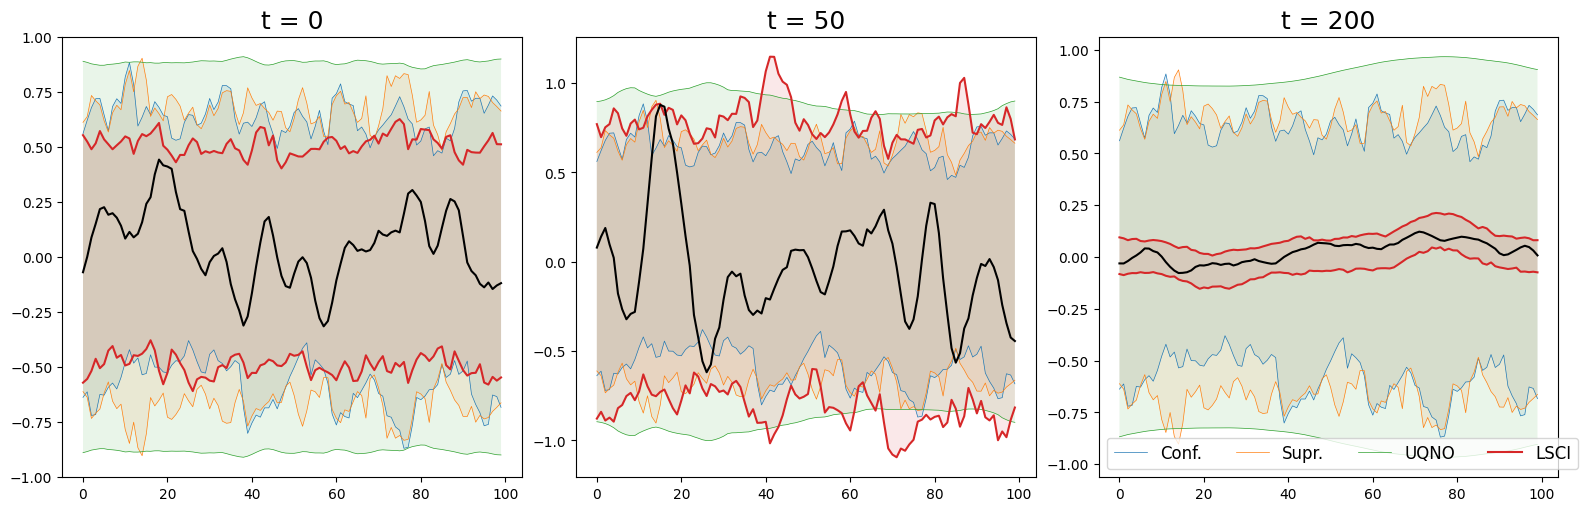

In [220]:
### examples
fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize = (16, 5))

n = [0, 50, 200]
s = np.arange(100)
for i in range(3):

    lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[n[i]], pca_state, alpha1, gamma1, 2000)
    uqno_lower, uqno_upper = uqn1_lower[n[i]], uqn1_upper[n[i]]

#     ax[i].set_ylim(-1.5, 1.5)
    ax[i].plot(conf_upper.squeeze(), c = 'C0', lw = 0.5, label = 'Conf.')
    ax[i].plot(conf_lower.squeeze(), c = 'C0', lw = 0.5)
    ax[i].plot(supr_upper.squeeze(), c = 'C1', lw = 0.5, label = 'Supr.')
    ax[i].plot(supr_lower.squeeze(), c = 'C1', lw = 0.5)
    ax[i].plot(uqno_upper, c = 'C2', lw = 0.5, label = 'UQNO')
    ax[i].plot(uqno_lower, c = 'C2', lw = 0.5)
    ax[i].plot(lsc1_upper, c = 'C3', lw = 1.5, label = 'LSCI')
    ax[i].plot(lsc1_lower, c = 'C3', lw = 1.5)
    ax[i].plot(rtest[n[i]], c = 'black')
    
    ax[i].fill_between(s, conf_lower.squeeze(), conf_upper.squeeze(), alpha = 0.1)
    ax[i].fill_between(s, supr_lower.squeeze(), supr_upper.squeeze(), alpha = 0.1)
    ax[i].fill_between(s, uqno_lower.squeeze(), uqno_upper.squeeze(), alpha = 0.1)
    ax[i].fill_between(s, lsc1_lower.squeeze(), lsc1_upper.squeeze(), alpha = 0.1)
    
    ax[i].set_title(f't = {n[i]}', fontsize = 18)
ax[-1].legend(ncol = 4, fontsize = 12)

plt.show()

In [143]:
# plt.imshow(vp[0])
# plt.colorbar()

In [ ]:
# u = swe.random_initial_condition()

# fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize = (15, 4))
# ax[0].imshow(swe.isht(swe.timestep(u, 0))[0])
# ax[1].imshow(swe.isht(swe.timestep(u, 10))[0])
# ax[2].imshow(swe.isht(swe.timestep(u, 100))[0])

In [ ]:
# plt.imshow(swe.isht(swe.timestep(u, 10))[0] - swe.isht(swe.timestep(u, 100))[0])
# plt.colorbar()

In [ ]:
# z_score = 3.27
# oracle_sd = np.std(rtest, axis = 1)
oracle_rc = []
oracle_width = []
for i in trange(0, ytest.shape[0]):
    
    # Oracle    
    oracle_lower = jnp.min(rtest[i]) * jnp.ones((92,)) - 1e-7
    oracle_upper = jnp.max(rtest[i]) * jnp.ones((92,)) + 1e-7
    oracle_rc.append(risk(oracle_lower, oracle_upper, rtest[i]))
    oracle_width.append(jnp.mean(oracle_upper - oracle_lower))

oracle_rc = np.array(oracle_rc)
oracle_width = np.array(oracle_width)

In [ ]:
noise_sd = np.std(rtest, axis = 1)

risk_control = np.mean(oracle_rc >= 0.99), \
               np.mean(conf_rc >= 0.99), \
               np.mean(supr_rc >= 0.99), \
               np.mean(uqn1_rc >= 0.99), \
               np.mean(lsc1_rc >= 0.99), \
               np.mean(lsc2_rc >= 0.99)

width = np.mean(oracle_width), \
        np.mean(conf_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = 0, \
           np.corrcoef([noise_sd, conf_rc])[0,1], \
           np.corrcoef([noise_sd, supr_rc])[0,1], \
           np.corrcoef([noise_sd, uqn1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc2_rc])[0,1]

width_cor = np.corrcoef([noise_sd, oracle_width])[0,1], \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [ ]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(metrics[i,j], 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)